In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline  
import pandas as pd
import scipy.sparse as sps

from Data_manager.Movielens.Movielens10MReader import Movielens10MReader
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [2]:
def load_URM(file_path):

    data = pd.read_csv(file_path)


    user_list = data['row'].tolist()
    item_list = data['col'].tolist()
    rating_list = data['data'].tolist()

    return sps.coo_matrix((rating_list, (user_list, item_list))).tocsr()

In [3]:
def load_ICM(file_path):

    data = pd.read_csv(file_path)

    item_list = data['row'].tolist()
    attribute_list = data['col'].tolist()
    rating_list = data['data'].tolist()

    return sps.coo_matrix((rating_list, (item_list, attribute_list))).tocsr()

In [4]:
URM_all = load_URM('input/data_train.csv')
ICM_all = load_ICM('input/data_ICM_genre.csv')
#print(ICM_all)

In [5]:
ICM_all.shape

(18059, 8)

In [6]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [7]:
print(features_per_item.shape)
print(items_per_feature.shape)

(18059,)
(8,)


In [8]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

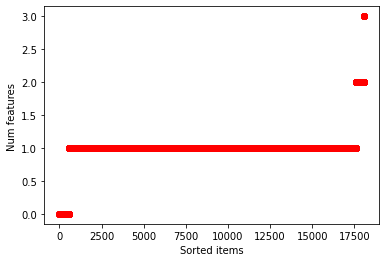

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

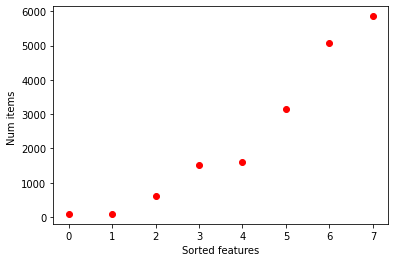

In [10]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

In [11]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13639 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13644 ( 0.0%) Users that have less than 1 test interactions


In [12]:
#import traceback

#try:
#    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
#except Exception as e:
#    traceback.print_exc()

In [13]:
#block_size = 100

#numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
#numerator_block.shape

In [14]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(ICM_all.T, shrink=0.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 18059 (100.0%), 7332.77 column/sec. Elapsed time 2.46 sec


<18059x18059 sparse matrix of type '<class 'numpy.float32'>'
	with 1749930 stored elements in Compressed Sparse Row format>

In [15]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCBFRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores


In [16]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 18059 (100.0%), 6756.75 column/sec. Elapsed time 2.67 sec


In [17]:
for user_id in range(10):
    print(recommender.recommend(user_id, at=5))

[ 7733 15609 15636  4116 15634]
[ 512 1030   74  371  579]
[ 9029  9322  7962 16365 16364]
[16875 14652  3957 17343 15646]
[ 9029  8974  9006  1607 17068]
[ 4795 10822 10810 14101 14100]
[13006  2062 10642  9614  7797]
[ 3228  2321 13592 13594 13595]
[5572 1766 6016 3208 3200]
[5980 4275 5074 5066 4170]


# Hyperparameters tuning

## Number of neighbors

In [18]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 8082.32 column/sec. Elapsed time 2.23 sec
EvaluatorHoldout: Processed 13644 (100.0%) in 3.45 sec. Users per second: 3957
ItemKNNCBFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 8325.47 column/sec. Elapsed time 2.17 sec
EvaluatorHoldout: Processed 13644 (100.0%) in 4.28 sec. Users per second: 3188
ItemKNNCBFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 7747.46 column/sec. Elapsed time

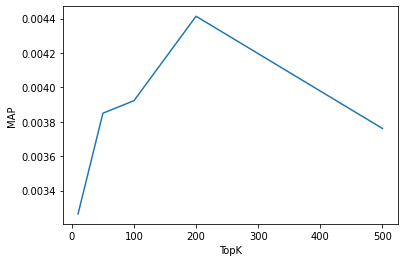

In [19]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### So we should take TopK = 100 (I guess)

## Shrinkage

In [20]:
x_tick = range(0,11)
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 7537.39 column/sec. Elapsed time 2.40 sec
EvaluatorHoldout: Processed 13644 (100.0%) in 4.83 sec. Users per second: 2825
ItemKNNCBFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 7621.48 column/sec. Elapsed time 2.37 sec
EvaluatorHoldout: Processed 13644 (100.0%) in 4.92 sec. Users per second: 2776
ItemKNNCBFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 7945.00 column/sec. Elapsed time

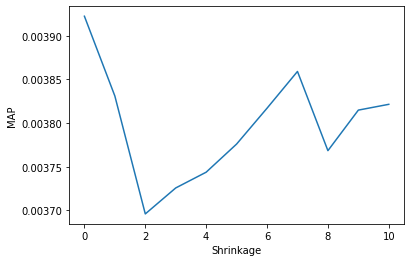

In [21]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### ...dafuq?

# Feature weighting

## IDF

In [22]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = np.ediff1d(sps.csc_matrix(ICM_all).indptr)

IDF = np.log(num_tot_items / items_per_feature)

print(ICM_all.shape)
print(IDF.shape)

(18059, 8)
(8,)


In [23]:
np.sort(items_per_feature)

array([  91,  103,  624, 1520, 1596, 3142, 5062, 5853], dtype=int32)

In [24]:
np.sort(IDF)

array([1.12668983, 1.27188251, 1.74878464, 2.42614368, 2.47493384,
       3.36524909, 5.16667047, 5.29053995])

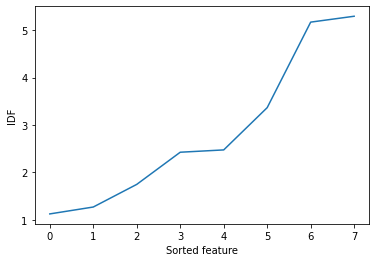

In [25]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

In [26]:
from scipy.sparse import diags
diags(IDF)

<8x8 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements (1 diagonals) in DIAgonal format>

In [27]:
ICM_idf = ICM_all.copy()
ICM_idf = ICM_idf*diags(IDF)

In [28]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_df.loc[10]

ItemKNNCBFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 7017.86 column/sec. Elapsed time 2.57 sec
EvaluatorHoldout: Processed 13644 (100.0%) in 4.54 sec. Users per second: 3008


PRECISION                      0.010386
PRECISION_RECALL_MIN_DEN       0.010395
RECALL                         0.001321
MAP                            0.002972
MAP_MIN_DEN                     0.00298
MRR                            0.027015
NDCG                           0.010022
F1                             0.002345
HIT_RATE                       0.095866
ARHR_ALL_HITS                  0.028322
NOVELTY                        0.008637
AVERAGE_POPULARITY             0.042426
DIVERSITY_MEAN_INTER_LIST      0.985525
DIVERSITY_HERFINDAHL           0.998545
COVERAGE_ITEM                  0.308876
COVERAGE_ITEM_CORRECT           0.03328
COVERAGE_USER                   0.99956
COVERAGE_USER_CORRECT          0.095824
DIVERSITY_GINI                  0.07358
SHANNON_ENTROPY               10.621173
RATIO_DIVERSITY_HERFINDAHL     0.998931
RATIO_DIVERSITY_GINI           0.297139
RATIO_SHANNON_ENTROPY          0.857355
RATIO_AVERAGE_POPULARITY        0.20978
RATIO_NOVELTY                  0.050803


#### Alternative feature weighting: BM25

# ...

In [29]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=100)

ItemKNNCBFRecommender: URM Detected 3 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 7591.54 column/sec. Elapsed time 2.38 sec


In [30]:
import pandas as pd
from tqdm import tqdm
submission = pd.DataFrame(columns=['user_id', 'item_list'])

for i in tqdm(range(13650), desc="getting recommendations"):
    item_list = recommender.recommend(i, 10)
    submission.loc[i] = [i, ' '.join([str(i) for i in item_list])]

submission

getting recommendations: 100%|██████████| 13650/13650 [00:14<00:00, 966.08it/s]


,user_id,item_list
0,0,2008 10943 16342 7001 12943 11057 6354 11613 3...
1,1,5241 5247 4843 5885 5599 5234 5900 1283 4940 4947
2,2,12132 9258 9640 12575 17344 1005 5603 3686 750...
3,3,17228 7715 11310 6675 2479 11311 15987 2471 24...
4,4,17553 8531 17911 17900 17259 17921 17578 10267...
...,...,...
13645,13645,14448 12584 15230 15785 15880 14917 1117 12556...
13646,13646,7483 7508 7455 12614 12549 12544 7506 12354 75...
13647,13647,615 4788 4852 13630 8572 11679 4837 9445 10753...
13648,13648,2987 4887 1185 12072 12073 13079 2154 12067 12...


In [31]:
from datetime import datetime
submission.to_csv(f'output/cbf_genre_{str(datetime.now())}.csv', index=False)